In [33]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timezone, timedelta
import os

id_dict = {}
path_dict = '/home/kisho_ucl/kisho_ws/warehouse_task_recognition/data/id_dict.txt'
with open(path_dict, "r") as file:
    for line in file:
        key, value = line.strip().split(": ")
        id_dict[int(key)] = int(value)
subid_dict = {value: key for key, value in id_dict.items()}



In [3]:
import torch
from torch.utils.data import Dataset

class IMUDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]


In [4]:
from copy import deepcopy
import os
import json


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_state = None
        self.best_epoch = 0

    def __call__(self, epoch, val_loss, model):
        # 初回、または改善したとき
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_state = deepcopy(model.state_dict())
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [ ]:
import numpy as np
import preprocess
import importlib
importlib.reload(preprocess)
from preprocess import load_session_trusco, window_split_trusco
from torch.utils.data import DataLoader, random_split

def build_loaders_for_subject(
    test_user,
    YDs,
    IDs,
    Hours,
    all_entries,
):

    X_train, y_train = [], []
    X_test,  y_test  = [], []

    for Year, Date in YDs:
        for ID in IDs:
            for h in Hours:

                if h not in all_entries or ID not in all_entries[h]:
                    continue

                imu, labels = load_session_trusco(ID, Year, Date, h)
                if imu is None:
                    continue

                # test_user 
                if ID == test_user:
                    X, y = window_split_trusco(
                        imu, labels,
                        window_size=256*20,
                        stride=256*1
                    )
                    valid = (y != -1)
                    X_test.append(X[valid])
                    y_test.append(y[valid])

                # train_user 
                else:
                    X, y = window_split_trusco(
                        imu, labels,
                        window_size=256*20,
                        stride=256*4
                    )
                    valid = (y != -1)
                    X_train.append(X[valid])
                    y_train.append(y[valid])

    # concat
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test  = np.concatenate(X_test)
    y_test  = np.concatenate(y_test)

    # Dataset 
    train_dataset = IMUDataset(X_train, y_train)
    test_dataset  = IMUDataset(X_test,  y_test)

    # train を train/valid に分割 
    train_len = int(len(train_dataset) * (1 - 0.1))
    valid_len = len(train_dataset) - train_len

    train_ds, valid_ds = random_split(
        train_dataset,
        [train_len, valid_len],
        generator=torch.Generator().manual_seed(42)
    )

    # DataLoader 
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

    print(f"[test_user={test_user}] Train={len(train_ds)}, Valid={len(valid_ds)}, Test={len(test_dataset)}")

    return train_loader, valid_loader, test_loader


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import os
import json


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_class_weights(train_loader, num_classes):
    counts = torch.zeros(num_classes)

    for _, labels in train_loader:
        for c in range(num_classes):
            counts[c] += (labels == c).sum()

    total = counts.sum()
    counts[counts == 0] = 1  # 0割回避
    weights = total / (num_classes * counts)
    
    return weights                                                                                                                                                                                                                                                                               


# Train one epoch
def train_one_epoch(classifier, loader, optimizer, criterion):
    classifier.train()
    total_loss = 0
    total_n = 0

    for signals, labels in loader:
        signals = signals.to(device)
        labels  = labels.to(device)

        logits = classifier(signals)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(labels)
        total_n    += len(labels)

    return total_loss / total_n



# Evaluate
def evaluate(classifier, loader, criterion=None):
    classifier.eval()
    total_loss = 0
    total_n = 0

    Y, P = [], []

    with torch.no_grad():
        for signals, labels in loader:
            signals = signals.to(device)
            labels  = labels.to(device)

            logits = classifier(signals)
            preds  = logits.argmax(dim=1)

            Y.extend(labels.cpu().numpy())
            P.extend(preds.cpu().numpy())

            if criterion is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item() * len(labels)
                total_n    += len(labels)

    if criterion is None:
        return Y, P, None
    else:
        return Y, P, total_loss / total_n

def record_results(test_user, y_true, y_pred,
                           results_dir="results_loso"):
    os.makedirs(results_dir, exist_ok=True)
    save_path = os.path.join(results_dir, f"{test_user}.json")

    result = {
        "user": test_user,
        "y_true": list(map(int, y_true)),
        "y_pred": list(map(int, y_pred))
    }
    with open(save_path, "w") as f:
        json.dump(result, f, indent=2)

    print(f"Saved: {save_path}")


In [34]:
import models
importlib.reload(models)
from models import SimCLR_new, CNN_Encoder, TaskClassifier_Transformer, TaskClassifier_LSTM

def build_model(model_type, use_pretrained=False, freeze_encoder=False):
    """
    model_type: 
        "lstm" | "prelstm" | "transformer" | "pretransformer"
    """

    # 1. Pretrained Encoder (SimCLR)
    pretrained_encoder = None
    if use_pretrained or ("pre" in model_type):
        sim = SimCLR_new(6, 256, 64, 128, 128, 4, 3, 64)
        sim.load_state_dict(torch.load("/home/kisho_ucl/kisho_ws/deep_HAR/trusco/experiments/model/0511/imu_encoder_100.pth", map_location="cpu"))
        pretrained_encoder = sim.encoder

    # 2. CNN Encoder selection
    if "pre" in model_type:
        encoder = pretrained_encoder
    else:
        encoder = CNN_Encoder(6, 256, 64, 128)

    # freeze の設定
    if freeze_encoder:
        for p in encoder.parameters():
            p.requires_grad = False

    # 3. Model selection

    # ---------- LSTM ----------
    if model_type == "cnn-lstm":
        return TaskClassifier_LSTM(
            encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
            lstm_hidden=128, lstm_layers=2, num_classes=3, freeze_encoder=False
        )

    if model_type == "precnn-lstm":
        return TaskClassifier_LSTM(
            encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
            lstm_hidden=128, lstm_layers=2, num_classes=3, freeze_encoder=True
        )

    # ---------- Transformer ----------
    if model_type == "cnn-t":
        return TaskClassifier_Transformer(
            encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
            num_heads=4, num_layers=3, num_classes=3, freeze_encoder=False
        )

    if model_type == "precnn-t":
        return TaskClassifier_Transformer(
            encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
            num_heads=4, num_layers=3, num_classes=3, freeze_encoder=True
        )


    # ----------------------------------------------------
    raise ValueError(f"Unknown model_type: {model_type}")


def build_optimizer(model, model_type, freeze_encoder):
    if freeze_encoder:
           print("encoder -> frozen")
           optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
           return optimizer
    
    else:
        if "cnn-lstm" in model_type:
            print("lr setting: encoder(1e-6), lstm(1e-4)")
            optimizer = torch.optim.Adam([
            {"params": model.encoder.parameters(),      "lr": 1e-6},
            {"params": model.lstm.parameters(),  "lr": 1e-4, "weight_decay": 1e-4},
            {"params": model.classifier.parameters(),   "lr": 1e-4, "weight_decay": 1e-4},
            ])
            return optimizer

        if "cnn-t" in model_type:
            print("lr setting: encoder(1e-6), transformer(1e-4)")
            optimizer = torch.optim.Adam([
            {"params": model.encoder.parameters(),      "lr": 1e-6},
            {"params": model.transformer.parameters(),  "lr": 1e-4, "weight_decay": 1e-4},
            {"params": model.classifier.parameters(),   "lr": 1e-4, "weight_decay": 1e-4},
            ])
            return optimizer

    raise ValueError("Unknown model type in optimizer")


In [ ]:
import models
importlib.reload(models)
from models import SimCLR_new, CNN_Encoder, TaskClassifier_Transformer, TaskClassifier_LSTM

# LOSO
def run_loso_one(train_loader, valid_loader, test_loader,weight_tensor,test_user="UNKNOWN",save_dir="results_loso", max_epochs=30, patience=5, model_type="None", freeze_encoder=False):

    # モデル構築
    classifier = build_model(model_type).to(device)
    optimizer = build_optimizer(classifier, model_type, freeze_encoder=True)

    weight_tensor = weight_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)


    # Early stopping
    early_stopper = EarlyStopping(patience=patience)

    # Training loop
    for epoch in range(1, max_epochs + 1):

        train_loss = train_one_epoch(classifier, train_loader, optimizer, criterion)
        _, _, valid_loss = evaluate(classifier, valid_loader, criterion)
        Y_tmp, P_tmp, test_loss = evaluate(classifier, test_loader, criterion)
        f1_tmp = f1_score(Y_tmp, P_tmp, average="weighted")

        print(
            f"[Epoch {epoch}/{max_epochs}] "
            f"Train={train_loss:.4f} | "
            f"Valid={valid_loss:.4f} | "
            f"Test={test_loss:.4f} | F1={f1_tmp:.4f}"
        )

        # early stopping check
        early_stopper(epoch, valid_loss, classifier)
        if early_stopper.early_stop:
            print("Early stopping.")
            break

    # Load best model
    classifier.load_state_dict(early_stopper.best_state)

    Y, P, _ = evaluate(classifier, test_loader, criterion)
    final_f1 = f1_score(Y, P, average="weighted")

    print(f"[{test_user}] Final F1 = {final_f1:.4f} | BestEpoch={early_stopper.best_epoch}")

    record_results(test_user, Y, P, results_dir=save_dir)

    return final_f1, Y, P, classifier

In [38]:
YDs = [[2024,1003]]
Hours = range(7,18,1)
IDs = range(0,39,1)

all_entries = {
    8: [1], 
    9: [21],  
    10: [13],                
    11: [2,6,9,23,27,36,16]  #
}

use_pretrained_model=True
freeze_encoder = False

if use_pretrained_model:
    print("LOOCV : PreCNN-Transformer")
else:
    print("LOOCV : CNN-Transformer")

for test_hour, subjects in all_entries.items():
    for test_subject in subjects:

        train_loader, valid_loader, test_loader = build_loaders_for_subject(
            test_user=test_subject,
            YDs=YDs,
            IDs=IDs,
            Hours=Hours,
            all_entries=all_entries,
        )

        num_classes = 3
        weight_tensor = compute_class_weights(train_loader, num_classes)
        print("Class weights:", weight_tensor.numpy())
        
        f1, Y, P, classifier = run_loso_one(
           train_loader, valid_loader, test_loader,
            weight_tensor,
            test_user=test_subject,
            save_dir="results_loso",
            max_epochs=20, patience=5,
            model_type="precnn-lstm",
            freeze_encoder=False
        )

        print(f"Subject={test_subject} F1={f1:.4f}")


LOOCV : PreCNN-Transformer
[test_user=1] Train=1742, Valid=194, Test=890
Class weights: [0.7064071 1.103929  1.4737732]
lr setting: encoder(1e-6), lstm(1e-4)
[Epoch 1/20] Train=1.0007 | Valid=0.7402 | Test=0.8144 | F1=0.5385
[Epoch 2/20] Train=0.6735 | Valid=0.6059 | Test=0.6693 | F1=0.6340
[Epoch 3/20] Train=0.5743 | Valid=0.4560 | Test=0.6612 | F1=0.7117
[Epoch 4/20] Train=0.4099 | Valid=0.3002 | Test=0.6086 | F1=0.7368
[Epoch 5/20] Train=0.3219 | Valid=0.3311 | Test=0.6175 | F1=0.7676
[Epoch 6/20] Train=0.2896 | Valid=0.2311 | Test=0.6471 | F1=0.7244
[Epoch 7/20] Train=0.2898 | Valid=0.3048 | Test=0.6869 | F1=0.7621
[Epoch 8/20] Train=0.2588 | Valid=0.2573 | Test=0.6813 | F1=0.7577
[Epoch 9/20] Train=0.2743 | Valid=0.1878 | Test=0.6743 | F1=0.7291
[Epoch 10/20] Train=0.2395 | Valid=0.2183 | Test=0.6914 | F1=0.7093
[Epoch 11/20] Train=0.2298 | Valid=0.2330 | Test=0.6267 | F1=0.7716
[Epoch 12/20] Train=0.2021 | Valid=0.2122 | Test=0.6849 | F1=0.7331
[Epoch 13/20] Train=0.1969 | Valid=

  LOSO RESULTS SUMMARY

[1] Mean per-user weighted F1
    → 0.8308655050861338

[2] Weighted F1 (all data concatenated)
    → 0.8433786427210841

[3] Macro F1 (all data concatenated)
    → 0.829155236508296

Per-user detail:
  1: 0.7145
  13: 0.8407
  16: 0.6132
  2: 0.7188
  21: 0.7323
  23: 1.0000
  27: 0.9254
  36: 0.9865
  6: 0.9826
  9: 0.7946


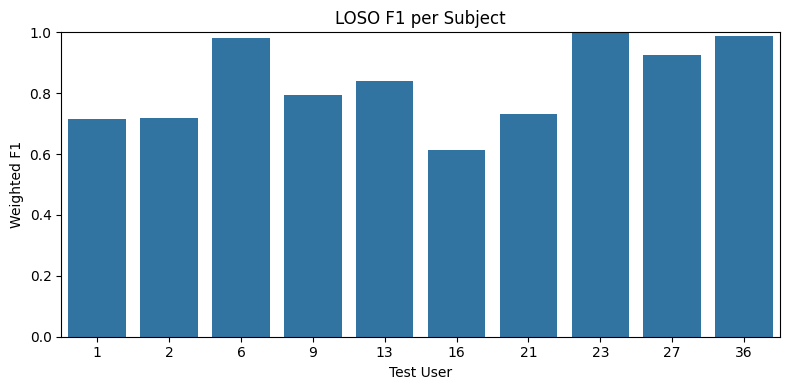

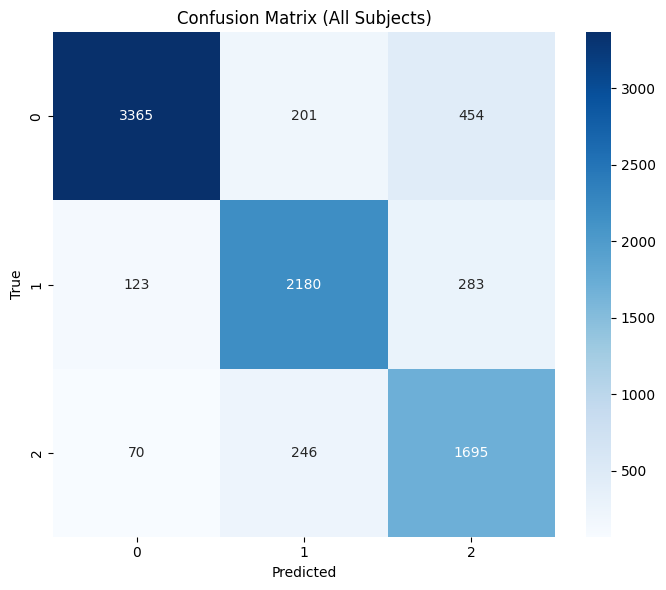

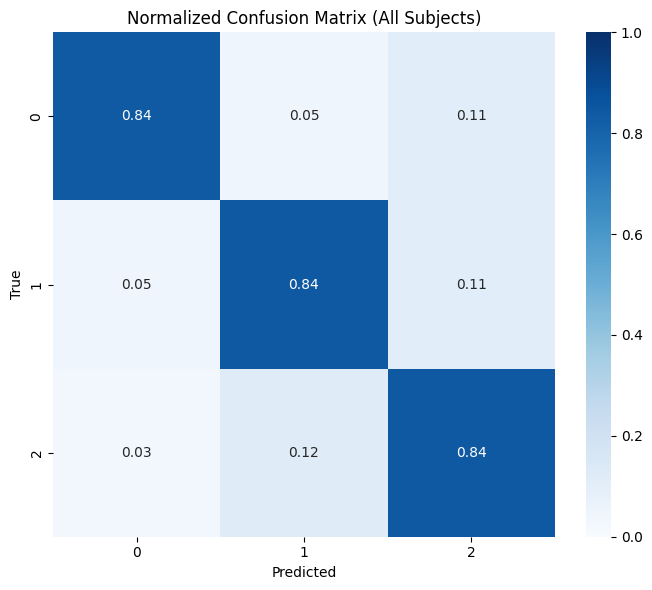

In [39]:
import os
import json
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results_dir = "./results_loso"
files = sorted(os.listdir(results_dir))

num_classes = 3

# per-user weighted F1 
f1_per_user = {}
all_y = []
all_p = []

for fname in files:
    with open(os.path.join(results_dir, fname)) as fp:
        res = json.load(fp)

    user = res["user"]
    y_true = np.array(res["y_true"])
    y_pred = np.array(res["y_pred"])

    f1_u = f1_score(y_true, y_pred, average="weighted")
    f1_per_user[user] = f1_u

    all_y.extend(y_true)
    all_p.extend(y_pred)

# all-user weighted F1
all_y = np.array(all_y)
all_p = np.array(all_p)

f1_all_weighted = f1_score(all_y, all_p, average="weighted")
f1_all_macro    = f1_score(all_y, all_p, average="macro")

# 3. overal confusion matrix
cm = confusion_matrix(all_y, all_p, labels=np.arange(num_classes))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

# results
print("============================================")
print("  LOSO RESULTS SUMMARY")
print("============================================")
print("\n[1] Mean per-user weighted F1")
print("    →", np.mean(list(f1_per_user.values())))

print("\n[2] Weighted F1 (all data concatenated)")
print("    →", f1_all_weighted)

print("\n[3] Macro F1 (all data concatenated)")
print("    →", f1_all_macro)

print("\nPer-user detail:")
for u, f1 in f1_per_user.items():
    print(f"  {u}: {f1:.4f}")


# plot f1 distribution
plt.figure(figsize=(8,4))
sns.barplot(x=list(f1_per_user.keys()), y=list(f1_per_user.values()))
plt.ylim(0,1)
plt.xlabel("Test User")
plt.ylabel("Weighted F1")
plt.title("LOSO F1 per Subject")
plt.tight_layout()
plt.show()

# plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (All Subjects)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (All Subjects)")
plt.tight_layout()
plt.show()
